In [1]:
from tensorflow.keras.models import model_from_json
import pickle
import numpy as np

In [23]:
def transform(X, standardizer):
    temp = X - standardizer.mean_
    temp = temp / standardizer.scale_
    return temp

def inverse_transform(X, standardizer):
    X*= standardizer.scale_
    X+= standardizer.mean_
    return X

In [3]:
class server_loaded_model():
    def __init__(self, fname_json, fname_h5, fname_standardizer):
        # load json and create model
        json_file = open(fname_json, 'r')#"cv_l2_1.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        # load weights into new model
        self.model.load_weights(fname_h5)#"cv_l2_1.h5")
        print("Loaded model from disk")
        self.model.compile()

        self.standardizer = pickle.load(open(fname_standardizer, 'rb'))#'standarizer.p', 'rb'))


    def perform_prediction(self, weather, building_params):
        weather = np.zeros((17*8760,))#self.standardizer[0].transform(weather)
        params = transform(building_params.reshape(1,-1), self.standardizer[1]).ravel()
        X = np.hstack((weather, params)).reshape(1,-1)
        print(self.model.predict(X))
        return inverse_transform(self.model.predict(X), self.standardizer[2])

In [4]:
m = server_loaded_model("cv_l2_1.json","cv_l2_1.h5", "standarizer.p")

Loaded model from disk


C:\Users\mr.pww\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\mr.pww\Anaconda3\Lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
a = m.perform_prediction(1,np.ones((13,)))

(1, 148933)


In [6]:
a[0]

array([1125.4761], dtype=float32)

In [4]:
import pandas as pd

In [5]:
def get_weather_file(fname):
    csvdata = open('../static/data/'+fname, 'r')
    colnames = ['year', 'month', 'day', 'hour', 'minute', 'data_source_unct',
                'temp_air', 'temp_dew', 'relative_humidity',
                'atmospheric_pressure', 'etr', 'etrn', 'ghi_infrared', 'ghi',
                'dni', 'dhi', 'global_hor_illum', 'direct_normal_illum',
                'diffuse_horizontal_illum', 'zenith_luminance',
                'wind_direction', 'wind_speed', 'total_sky_cover',
                'opaque_sky_cover', 'visibility', 'ceiling_height',
                'present_weather_observation', 'present_weather_codes',
                'precipitable_water', 'aerosol_optical_depth', 'snow_depth',
                'days_since_last_snowfall', 'albedo',
                'liquid_precipitation_depth', 'liquid_precipitation_quantity']

    columns_to_drop = ['year', 'month', 'day', 'hour', 'minute', 'data_source_unct', 
                       'present_weather_observation', 'precipitable_water', 'days_since_last_snowfall', 
                       'liquid_precipitation_depth', 'liquid_precipitation_quantity', 'etrn', 'zenith_luminance', 
                       'aerosol_optical_depth', 'albedo', 'ceiling_height', 'present_weather_codes', 'visibility']

    # We only have to skip 6 rows instead of 7 because we have already used
    # the realine call above.
    firstline = csvdata.readline()
    data = pd.read_csv(csvdata, skiprows=6, header=0, names=colnames).drop(columns=columns_to_drop)
    return data

In [6]:
standardizer = pickle.load(open('standardizer_hourly.p', 'rb'))

C:\Users\mr.pww\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\mr.pww\Anaconda3\Lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [43]:
df = get_weather_file('CAN_ON_Toronto-Pearson.Intl.AP.716240_TMYx.2004-2018.epw')
weather = transform(df, standardizer[0]).values.transpose().ravel()


In [22]:
df.to_csv('../test_weather.csv')

In [31]:
df_test = pd.read_csv('../test.csv', index_col='Unnamed: 0')
df_test.index = pd.to_datetime(df_test.index)

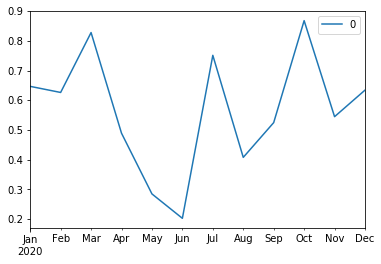

In [32]:
df_test.resample('M').sum().plot()

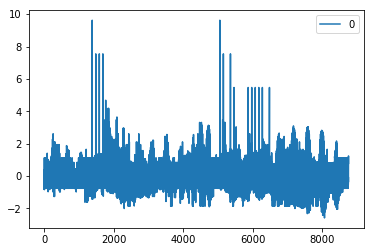

In [10]:
i=2
pd.DataFrame(weather[i*8760:(i+1)*8760]).plot()

In [16]:
b = df - standardizer[0].mean_

In [17]:
b.temp_air.plot()

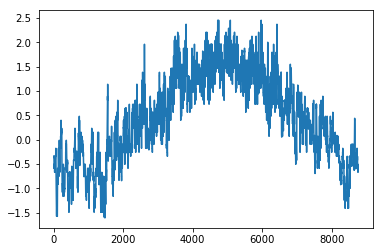

In [44]:
import matplotlib.pyplot as plt
plt.plot(weather[:8760])